# Probability for sampling $K$ out of $n$ total population and find no positive

The general setup of this problem can be described as following:

- We have $n$ total data points ($n$ is large), and then we need to sample $k$ from these points for expensive observation (e.g. manual inspection).
- There are $x$ data points, within $n$ total population we have, are positive (i.e. having the property that we have).
- Within $k$ samples, we observe $\hat{x}$ positive data points.
- Given observation we have $\hat{x} \in \{0, 1, \cdots, k\}$ (note we included 0 to indicate thre can be no such property), what is the probability distribution of $x$?




As I am very Bayesian person, so I decided to approach this problem in a Bayesian way, the above question to me is equivalent to solve the following:
\begin{align}
	\mathbb{P}(X_n=x|\hat{X}_k=\hat{x}) = \frac{\mathbb{P}(\hat{X}_k=\hat{x}|X_n=x)\mathbb{P}(X_n=x)}{\mathbb{P}(\hat{X}_k=\hat{x})}
\end{align}
where
- $X_n$ is the random variable where given $n$ total population, you observed $X$ positives.
- $\hat{X}_k$ is the random variable where given $k$ sample, you observed $\hat{X}$ positives.
- $\mathbb{P}(X_n=x|\hat{X}_k=\hat{x})$ is the probability distribution of observing $X$ number of positives within total $n$ population, given we have observed $\hat{x}$ within our sample.

Naturally, we start with uninformative prior $\mathbb{P}(X_n)= \frac{1}{n+1}$ (notice the $n+1$ here is to include the possibility of zero positives), the normalising constant is
\begin{align}
	\mathbb{P}(\hat{X}_k=\hat{x}) = \sum_{i=0}^n \mathbb{P}(\hat{X}_k=\hat{x}|X_n=i)
\end{align}

The interesting bit lies in the calculation of the posterior distribution. Consider an instance here:
\begin{align}
\mathbb{P}(\hat{X}_2=0|X_3=2)
\end{align}
with a total population $n=3$, and we have 1 positive, what is the probability of seeing 0 positive from a random sample of 2?

Let's go back to basics, assume each datapoint is $A$, $B$ and $C$, and when sample 2, we have a combination of $AB$, $AC$, $BC$, and without loss of generality, assume that one postive data point is $C$. Then it means we have 1/3 of chance to observe 0 positive if we sample 2.

What about 4? We have $AB$, $AC$, $AD$, $BC$, $BD$, $CD$, we have 1/2. Now we generalise this into a formula:
\begin{align}
\mathbb{P}(\hat{X}_k=0|X_n=x)& = \frac{C_k^{n-x}}{C_k^{n}}  \\
						& = \frac{(n-x)!}{k!(n-x-k)!}  \frac{k!(n-k)!}{n!} \\
						& = \frac{\Pi_{i=0}^{x-1}(n-k-i)}{\Pi_{i=0}^{x-1}(n-i)}
\end{align}


# Quick implementation
Implementing it in python is easy. *However*, there's a trap: the formula $\frac{\Pi_{i=0}^{x-1}(n-k-i)}{\Pi_{i=0}^{x-1}(n-i)}$ is actually very subtle and subject to overflow. The following is a good example:

In [47]:

n = 200
x = 10
k = 10
num = [n-k-i for i in range(x)]
denom = [n-i for i in range(x)]
np.prod(num)/np.prod(denom)

-0.31230157279729737

In the above one, we have total population of 200, and there are 10 positives, and we sampled 10 from it, the probability of seeing 0 positive in the sample, interestingly from the calculation, is *negative*.

This is because the denominator gets too large, it becomes a negative number:
```python
denom
[200, 199, 198, 197, 196, 195, 194, 193, 192, 191]
np.prod(denom)
-9064137027699023872
```
Of course an elegant way of solving this is to change the way $\frac{\Pi_{i=0}^{x-1}(n-k-i)}{\Pi_{i=0}^{x-1}(n-i)}$ is calculated. Alternatively, a mentally lazy way of calculating it is to improve the precision of float to double by use `np.float64`.


In [57]:
import numpy as np
def prob_finding_zero(x, k, n):
    num = np.array([n-k-i for i in range(x)], dtype=np.float64)
    denom = np.array([n-i for i in range(x)],  dtype=np.float64)
    return np.prod(num)/np.prod(denom)

n = 200
x = 10
k = 10
prob_finding_zero(x, k, n)


0.5914521339185829

Now this makes more sense...

Now back to our problem, if we have $n=2000$ data, and we sample $k$ data points, what is the distribution?

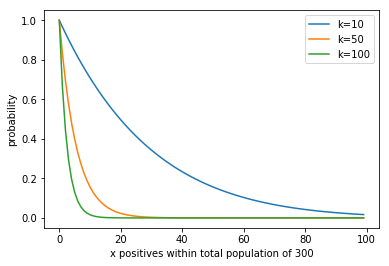

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

n = 300
x_max = 100
plt.plot([prob_finding_zero(x, k=10, n=n) for x in range(0,x_max)])
plt.plot([prob_finding_zero(x, k=50, n=n) for x in range(0,x_max)])
plt.plot([prob_finding_zero(x, k=100, n=n) for x in range(0,x_max)])
plt.legend(["k=10", "k=50", "k=100"])
plt.ylabel("probability")
plt.xlabel(f"x positives within total population of {n}")
plt.show()

we can see the probability of observing zero positives drops to zero as natural positive $x$ increases, and the larger the sample size $k$, the faster the drop is.

Now it is time to sum up and get our problem: given $n$ total population, and there are $x$ positives in it, what is the probability we find zero positive if we sample $k$ from $n$:

\begin{align}
	\mathbb{P}(X_n=0|\hat{X}_k=\hat{x}) = \frac{\mathbb{P}(\hat{X}_k=0|X_n=x)\mathbb{P}(X_n=x)}{\mathbb{P}(\hat{X}_k=0)}
\end{align}
We have already our prior, posterior, and for the normalising constant, we get
\begin{align}
	\mathbb{P}(\hat{X}_k=0) = \sum_{i=0}^n \mathbb{P}(\hat{X}_k=0|X_n=i)
\end{align}

The final result can be calculate by the following code:

check sum of distribution 1 0.9999999999999999
check sum of distribution 2 1.0000000000000004
check sum of distribution 3 0.9999999999999994


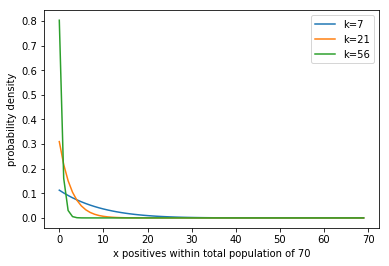

In [124]:
get_normalising_constant = lambda k, n, x_max=n: sum([prob_finding_zero(x=x, k=k, n=n)*1/(n+1) for x in range(x_max+1)])

n = 70
x_max = n # if it gets too big, we will have numerical error
k1 = int(.1*n)
k2 = int(.3*n)
k3 = int(.8*n)

norm_const1 = get_normalising_constant(k1, n, x_max=x_max)
dist1 = [prob_finding_zero(x, k=k1, n=n)*1/(n+1)/norm_const1 for x in range(0,x_max)]
print("check sum of distribution 1", sum(dist1))

norm_const2 = get_normalising_constant(k2, n, x_max=x_max)
dist2 = [prob_finding_zero(x, k=k2, n=n)*1/(n+1)/norm_const2 for x in range(0,x_max)]
print("check sum of distribution 2", sum(dist2))

norm_const3 = get_normalising_constant(k3, n, x_max=x_max)
dist3 = [prob_finding_zero(x, k=k3, n=n)*1/(n+1)/norm_const3 for x in range(0,x_max)]
print("check sum of distribution 3", sum(dist3))



plt.plot(dist1)
plt.plot(dist2)
plt.plot(dist3)
plt.legend([f"k={k1}", f"k={k2}", f"k={k3}"])
plt.ylabel("probability density")
plt.xlabel(f"x positives within total population of {n}")
plt.show()


Now, what conclusion we can draw from the above graph?

- For starters, if we want to be sure that 